In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 23.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 28.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 69.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 69.2 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import random
import os

import torch
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

def reset_seeds(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

SEED = 42

# 현재 device 확인
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [4]:
DATA_PATH = '/content/drive/MyDrive/2조_누구냐, 넌!/04. 기타자료/Naver_shopping_크롤링/Modeling/한수길/data/'

In [5]:
DATA_PATH_model = '/content/drive/MyDrive/2조_누구냐, 넌!/04. 기타자료/Naver_shopping_크롤링/Modeling/한수길/data/'

In [6]:
df = pd.read_csv(f"{DATA_PATH}train_emotion.csv")
df

,content,score,date,brand,가격,세정력/거품,향기,트러블/진정,배송/서비스/고객대응,탈모 효과 및 쿨링감,머릿결*
0,시원하고 좋은데 뾰루지 많이나고 따갑네요,1,23.09.07.,라보에이치,NaN,NaN,NaN,0.0,NaN,NaN,NaN
1,저랑은 안맞네요 계속 쓰다보니 두피 너무 가렵고 비듬각질이 생기네요,1,23.02.18.,라보에이치,NaN,NaN,NaN,0.0,NaN,NaN,NaN
2,효과는없고 계속많이빠져요,1,22.07.27.,라보에이치,NaN,NaN,NaN,NaN,NaN,0.0,NaN
3,"제품이 어떤지는 잘 모르겠고요, 아모레퍼시픽이 소비자 생각 안 하는 회사인 건 확실...",1,22.04.05.,라보에이치,NaN,NaN,NaN,NaN,0.0,NaN,NaN
4,ㅋㅋ최악이에요 진짜.. 3월1일에 주문했는데 3월 30일인 오늘 도착했네요 그냥 취...,1,22.03.30.,라보에이치,NaN,NaN,NaN,NaN,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
4731,머리빠짐이 덜한것 같은데 일단 더 사용해 볼게요~ 무엇보다 샴푸를 쓰고 나면 타샴푸...,5,21.11.25.,반코르,NaN,NaN,1.0,1.0,NaN,NaN,1.0
4732,확실히 기름기랑 두피여드름이 줄었어요,5,22.01.12.,반코르,NaN,NaN,NaN,1.0,NaN,NaN,NaN
4733,1. 머리 덜 간지러움 2. 각질 비듬 줄어듬 3. 머리카락이 두꺼워지는게 느껴짐 ...,5,21.12.12.,반코르,NaN,NaN,NaN,1.0,NaN,1.0,NaN
4734,지성두피라서 오후만 되면 앞머리 떡지던 사람으로서 이정도로 만족스러운 샴푸는 처음입...,5,21.12.01.,반코르,NaN,1.0,NaN,NaN,NaN,NaN,1.0


In [7]:
df = df.dropna(subset='가격', axis=0).reset_index(drop=True)

In [8]:
df

,content,score,date,brand,가격,세정력/거품,향기,트러블/진정,배송/서비스/고객대응,탈모 효과 및 쿨링감,머릿결*
0,한달정도 사용해봤는데 다른 맥주효모삼푸와달리 효과가 전혀없습니다. 가격이 싼데는 이...,1,23.06.14.,이지마인드,1.0,NaN,NaN,NaN,NaN,NaN,NaN
1,400그람작은병이었네요. 비싸게 샀네요.,2,23.01.27.,라보에이치,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2,대용량으로 가성비는 좋은데 두피 트러블이 심해지는 건지 아님 트러블 개선에 도움이 ...,2,21.02.28.,이지마인드,1.0,NaN,NaN,0.0,NaN,0.0,NaN
3,가성비 좋은 짐승용량에 향이 좋은 건 맞습니다. 그러나 지성이신 분들께 맞지 않습니...,2,21.01.10.,이지마인드,1.0,NaN,NaN,0.0,NaN,NaN,NaN
4,비듬많고 기름좀 있고 지루성 약간 있어서 나름 화해에서 검색해보고 삼. 20가지 주...,2,20.10.06.,이지마인드,1.0,0.0,0.0,0.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
962,일단 처음보고 양이 꽤 많아서 만족했구요 사용한지 한달정도? 된것같은데 사실 변화는...,5,22.10.23.,반코르,1.0,NaN,NaN,NaN,NaN,NaN,1.0
963,11 저렴한 가격에 득템! 머릿결이 두꺼워졌으면 좋겠어요 효과보길 기대합니다,5,22.11.04.,반코르,1.0,NaN,NaN,NaN,NaN,NaN,NaN
964,2번째 구매입니다 비싼값 하는 듯합니다 일반샴푸는 비듬이랑 탈모를 못잡아서 바꿨는데...,5,22.07.04.,반코르,0.0,NaN,NaN,1.0,NaN,1.0,NaN
965,하나 사서 쓰는도중이 남동생이 가져가서 다시 하나 더 사서 지금 바닥 거의보여서 다...,5,22.01.27.,반코르,0.0,NaN,NaN,NaN,NaN,1.0,1.0


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 967 entries, 0 to 966
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   content      967 non-null    object 
 1   score        967 non-null    int64  
 2   date         967 non-null    object 
 3   brand        967 non-null    object 
 4   가격           967 non-null    float64
 5   세정력/거품       242 non-null    float64
 6   향기           162 non-null    float64
 7   트러블/진정       149 non-null    float64
 8   배송/서비스/고객대응  105 non-null    float64
 9   탈모 효과 및 쿨링감  141 non-null    float64
 10  머릿결*         108 non-null    float64
dtypes: float64(7), int64(1), object(3)
memory usage: 83.2+ KB


In [10]:
target = df.iloc[:,4].to_numpy().reshape(-1,1)
target

array([[1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],

In [11]:
target = np.where(target==1, 0, 1)

In [12]:
model_name = "jaehyeong/koelectra-base-v3-generalized-sentiment-analysis"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

In [21]:
train_token = tokenizer(df['content'].tolist(), padding="max_length", max_length = 512, truncation=True)

In [22]:
input_ids = np.array(train_token['input_ids'])
attention_mask = np.array(train_token['attention_mask'])
token_type_ids = np.array(train_token['token_type_ids'])

input_ids.shape, attention_mask.shape, token_type_ids.shape

((967, 512), (967, 512), (967, 512))

In [23]:
class ReviewDataset(torch.utils.data.Dataset):
    def __init__(self, input_ids, attention_mask, token_type_ids, y_1=None, y_2=None):
        self.input_ids = input_ids
        self.attention_mask = attention_mask
        self.token_type_ids = token_type_ids
        self.y_1 = y_1


    def __len__(self):
        return self.input_ids.shape[0]

    def __getitem__(self, idx):
        item = {}
        item['input_ids'] = torch.tensor(self.input_ids[idx])
        item['attention_mask'] = torch.tensor(self.attention_mask[idx])
        item['token_type_ids'] = torch.tensor(self.token_type_ids[idx])
        if self.y_1 is not None:
            item['y_1'] = torch.Tensor(self.y_1[idx])

        return item

In [24]:
class Net(torch.nn.Module):
    def __init__(self, model_name):
        super().__init__()
        self.model = AutoModel.from_pretrained(model_name)
        self.output_layer = torch.nn.Linear( self.model.config.hidden_size , 1)

    def forward(self, input_ids, attention_mask, token_type_ids):
        x = self.model(input_ids, attention_mask, token_type_ids)
        x = self.output_layer(x[0][:,0])
        return x

In [25]:
def train_loop(dataloader, model, bce_loss_fn, optimizer, device):
    epoch_loss = 0
    model.train() # 모델 객체를 학습모드로 전환
    for batch in tqdm(dataloader):
        pred = model(batch["input_ids"].to(device), batch['attention_mask'].to(device), batch['token_type_ids'].to(device))

        # 이진분류 loss
        bce_loss = bce_loss_fn(pred, batch["y_1"].to(device))

        optimizer.zero_grad()
        bce_loss.backward()
        optimizer.step()

        epoch_loss += bce_loss.item()

    epoch_loss /= len(dataloader)

    return epoch_loss

In [26]:
@torch.no_grad()
def test_loop(dataloader,model,bce_loss_fn, device):
    model.eval() # 평가 모드
    sig = torch.nn.Sigmoid()
    pred_1_list = []

    epoch_loss = 0
    for batch in tqdm(dataloader):
        pred = model(batch["input_ids"].to(device), batch['attention_mask'].to(device), batch['token_type_ids'].to(device))

        # 검증 평가할 경우
        if batch.get("y_1") is not None:
            bce_loss = bce_loss_fn(pred, batch["y_1"].to(device))

            epoch_loss += bce_loss.item()

        # 예측값 만들기
        pred_1 = sig(pred).to("cpu").numpy()

        pred_1_list.append(pred_1)

    pred_1 = np.concatenate(pred_1_list)
    epoch_loss /= len(dataloader)
    return epoch_loss, pred_1

In [27]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, precision_score, recall_score

batch_size = 4
bce_loss_fn = torch.nn.BCEWithLogitsLoss()
epochs = 100
n_splits = 5
cv = StratifiedKFold(n_splits=n_splits, random_state=SEED, shuffle=True)

In [28]:
is_holdout = False
reset_seeds(SEED)
best_score_list = []
best_recall_score_list = []
best_precision_score_list = []

for i, (tri, vai) in enumerate(cv.split(input_ids, target)):
    model = Net(model_name).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

    # 학습용
    train_dt = ReviewDataset(input_ids[tri], attention_mask[tri], token_type_ids[tri], target[tri])
    train_dl = torch.utils.data.DataLoader(train_dt, batch_size=batch_size, shuffle=True)

    # 검증용
    valid_dt = ReviewDataset(input_ids[vai], attention_mask[vai], token_type_ids[vai], target[vai])
    valid_dl = torch.utils.data.DataLoader(valid_dt, batch_size=batch_size, shuffle=False)

    best_score = 0
    best_recall_score = 0
    best_precision_score = 0


    patience = 0
    for epoch in tqdm(range(epochs)):
        train_loss = train_loop(train_dl, model, bce_loss_fn, optimizer, device)
        valid_loss, pred= test_loop(valid_dl, model, bce_loss_fn, device)

        # multi-label Classification
        pred = (pred > 0.5).astype(int)
        f1 = f1_score(target[vai], pred)
        recall = recall_score(target[vai], pred)
        precision = precision_score(target[vai], pred)
        patience += 1

        if best_score < f1:
            patience = 0
            best_score = f1
            best_recall_score = recall
            best_precision_score = precision
            torch.save(model.state_dict(), f"{DATA_PATH_model}model_emotion_price_{i}.pth")

        print("f1_score_1:", f1)
        print("recall:", recall)
        print("precision:", precision)
        print("train_loss:", train_loss)
        print("valid_loss:", valid_loss)
        if patience == 2:
            break

    print(f"{i} 번째 폴드 best f1_score_1: {best_score}")
    print(f"{i} 번째 폴드 best recall_score: {best_recall_score}")
    print(f"{i} 번째 폴드 best precision_score: {best_precision_score}")
    best_score_list.append(best_score)
    best_recall_score_list.append(best_recall_score)
    best_precision_score_list.append(best_precision_score)
    if is_holdout:
        break

print(np.mean(best_score_list))
print(np.mean(best_recall_score_list))
print(np.mean(best_precision_score_list))

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

f1_score_1: 0.6976744186046512
recall: 0.6
precision: 0.8333333333333334
train_loss: 0.33371283461522194
valid_loss: 0.19151813088327038


  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

f1_score_1: 0.782608695652174
recall: 0.72
precision: 0.8571428571428571
train_loss: 0.13233878184109926
valid_loss: 0.14665793680718966


  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

f1_score_1: 0.7916666666666667
recall: 0.76
precision: 0.8260869565217391
train_loss: 0.058398512254478695
valid_loss: 0.17194014307757727


  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

f1_score_1: 0.7916666666666667
recall: 0.76
precision: 0.8260869565217391
train_loss: 0.0300345102531509
valid_loss: 0.21653106935056193


  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

f1_score_1: 0.7906976744186047
recall: 0.68
precision: 0.9444444444444444
train_loss: 0.026918439669822603
valid_loss: 0.1997497818879403
0 번째 폴드 best f1_score_1: 0.7916666666666667
0 번째 폴드 best recall_score: 0.76
0 번째 폴드 best precision_score: 0.8260869565217391


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

f1_score_1: 0.5641025641025641
recall: 0.44
precision: 0.7857142857142857
train_loss: 0.3146066009883106
valid_loss: 0.1754506043329531


  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

f1_score_1: 0.8235294117647058
recall: 0.84
precision: 0.8076923076923077
train_loss: 0.15794776632575339
valid_loss: 0.1079904525635802


  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

f1_score_1: 0.8181818181818181
recall: 0.72
precision: 0.9473684210526315
train_loss: 0.05067727101496277
valid_loss: 0.16081919290163382


  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

f1_score_1: 0.8571428571428572
recall: 0.84
precision: 0.875
train_loss: 0.06103882059147678
valid_loss: 0.08862323548682795


  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

f1_score_1: 0.8627450980392156
recall: 0.88
precision: 0.8461538461538461
train_loss: 0.0128727377387551
valid_loss: 0.10064021235674012


  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

f1_score_1: 0.8679245283018867
recall: 0.92
precision: 0.8214285714285714
train_loss: 0.011024619363843626
valid_loss: 0.14043574000005515


  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

f1_score_1: 0.8846153846153846
recall: 0.92
precision: 0.8518518518518519
train_loss: 0.00519836162092145
valid_loss: 0.14019303354767285


  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

f1_score_1: 0.88
recall: 0.88
precision: 0.88
train_loss: 0.004231294871490334
valid_loss: 0.1382967067445267


  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

f1_score_1: 0.88
recall: 0.88
precision: 0.88
train_loss: 0.0035845791145717515
valid_loss: 0.1451497336692766
1 번째 폴드 best f1_score_1: 0.8846153846153846
1 번째 폴드 best recall_score: 0.92
1 번째 폴드 best precision_score: 0.8518518518518519


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

f1_score_1: 0.45
recall: 0.375
precision: 0.5625
train_loss: 0.3248782582753866
valid_loss: 0.24562290827838743


  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

f1_score_1: 0.8214285714285714
recall: 0.9583333333333334
precision: 0.71875
train_loss: 0.15887219747816472
valid_loss: 0.12373366364639024


  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

f1_score_1: 0.8461538461538461
recall: 0.9166666666666666
precision: 0.7857142857142857
train_loss: 0.0759643972995355
valid_loss: 0.11523468903627018


  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

f1_score_1: 0.8799999999999999
recall: 0.9166666666666666
precision: 0.8461538461538461
train_loss: 0.055185392441362446
valid_loss: 0.11086666405828176


  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

f1_score_1: 0.8
recall: 1.0
precision: 0.6666666666666666
train_loss: 0.029586390119295605
valid_loss: 0.16570745578643922


  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

f1_score_1: 0.8444444444444444
recall: 0.7916666666666666
precision: 0.9047619047619048
train_loss: 0.030844809333841827
valid_loss: 0.09522532620372212
2 번째 폴드 best f1_score_1: 0.8799999999999999
2 번째 폴드 best recall_score: 0.9166666666666666
2 번째 폴드 best precision_score: 0.8461538461538461


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

f1_score_1: 0.7843137254901961
recall: 0.8
precision: 0.7692307692307693
train_loss: 0.31862751374347614
valid_loss: 0.24489046503998796


  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

f1_score_1: 0.830188679245283
recall: 0.88
precision: 0.7857142857142857
train_loss: 0.1351043467899573
valid_loss: 0.1656744365713426


  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

f1_score_1: 0.8235294117647058
recall: 0.84
precision: 0.8076923076923077
train_loss: 0.045759373843746703
valid_loss: 0.17370668936482803


  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

f1_score_1: 0.92
recall: 0.92
precision: 0.92
train_loss: 0.033922965647940784
valid_loss: 0.17935209190567994


  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

f1_score_1: 0.8679245283018867
recall: 0.92
precision: 0.8214285714285714
train_loss: 0.02711552435522611
valid_loss: 0.21338357902322042


  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

f1_score_1: 0.8148148148148148
recall: 0.88
precision: 0.7586206896551724
train_loss: 0.00919282545945271
valid_loss: 0.261292689365848
3 번째 폴드 best f1_score_1: 0.92
3 번째 폴드 best recall_score: 0.92
3 번째 폴드 best precision_score: 0.92


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

f1_score_1: 0.7142857142857143
recall: 0.6
precision: 0.8823529411764706
train_loss: 0.33379791813336085
valid_loss: 0.18095301422385537


  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

f1_score_1: 0.8260869565217391
recall: 0.76
precision: 0.9047619047619048
train_loss: 0.15819430541362345
valid_loss: 0.09775784149841994


  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

f1_score_1: 0.9259259259259259
recall: 1.0
precision: 0.8620689655172413
train_loss: 0.06964231957441445
valid_loss: 0.04798462794979616


  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

f1_score_1: 0.9387755102040817
recall: 0.92
precision: 0.9583333333333334
train_loss: 0.02999137809557706
valid_loss: 0.05476556601934135


  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

f1_score_1: 0.9090909090909091
recall: 1.0
precision: 0.8333333333333334
train_loss: 0.03111445130156257
valid_loss: 0.07316300305727945


  0%|          | 0/194 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

f1_score_1: 0.923076923076923
recall: 0.96
precision: 0.8888888888888888
train_loss: 0.018463907961387995
valid_loss: 0.04746370759735606
4 번째 폴드 best f1_score_1: 0.9387755102040817
4 번째 폴드 best recall_score: 0.92
4 번째 폴드 best precision_score: 0.9583333333333334
0.8830115122972264
0.8873333333333333
0.880485197572154


In [29]:
DATA_PATH_test = '/content/drive/MyDrive/2조_누구냐, 넌!/04. 기타자료/Naver_shopping_크롤링/Modeling/한수길/data/'

In [30]:
test = pd.read_csv(f"{DATA_PATH_test}test_emotion.csv")
test

,content,score,date,brand,가격,세정력/거품,향기,트러블/진정,배송/서비스/고객대응,탈모 효과 및 쿨링감,머릿결*
0,배송누락되어 본사확신다고 하시고 다시 주문번호 올려달라고 하시니 대응절차가 문제있어...,1,23.08.31.,라보에이치,NaN,NaN,NaN,NaN,0.0,NaN,NaN
1,전에 쓰던 샴푸보다 머리카락 더빠짐…,1,23.03.25.,라보에이치,NaN,NaN,NaN,NaN,NaN,0.0,NaN
2,사용감은 더 느껴봐야겠지만 1회 사용해보니 젤 고민스러운 정수리엔 효과적이지 않네요...,1,21.06.13.,라보에이치,NaN,NaN,NaN,NaN,0.0,NaN,NaN
3,머리카락 끝이 엉키고 ㅠ비듬그대로 ㅡㅡ그냥 아까워서 쓰고 있어요 ....두피 여드름...,1,20.12.18.,라보에이치,NaN,NaN,NaN,0.0,NaN,0.0,0.0
4,세정력은 낮고 일단 두피가 따갑고 피부트러블이 생깁니다,1,20.12.26.,라보에이치,NaN,0.0,NaN,0.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
1179,머릿결이 부드러워요,5,22.01.27.,반코르,NaN,NaN,NaN,NaN,NaN,NaN,1.0
1180,출산후 머리가 엄청 빠진다고 해서 임신했을때부터 썼습니다 제가 쓰려고 산 건데 남편...,5,21.12.17.,반코르,NaN,NaN,NaN,1.0,NaN,NaN,NaN
1181,출산한지 3개월에 단유하고 나니 호르몬이 돌아오면서 임신전 두피에 지루피부염이 다시...,5,21.12.08.,반코르,NaN,NaN,NaN,1.0,NaN,NaN,NaN
1182,머릿결이 좀 좋아졌어요 거품도 잘 나서 만족해요,5,21.12.12.,반코르,NaN,1.0,NaN,NaN,NaN,NaN,1.0


In [31]:
test = test.dropna(subset='가격', axis=0).reset_index(drop=True)

In [32]:
test

,content,score,date,brand,가격,세정력/거품,향기,트러블/진정,배송/서비스/고객대응,탈모 효과 및 쿨링감,머릿결*
0,싼맛에 삽니다 배송은 빨라요,2,22.01.02.,이지마인드,1.0,NaN,NaN,NaN,1.0,NaN,NaN
1,탈모샴푸 너무 비싸요 ㅠㅠ매번 사기는 부담이네요,3,22.06.16.,라보에이치,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2,탈모방지는 아직 모르겠고 ㄱㅏ격이 많이 비싼것같아요,3,21.02.05.,라보에이치,0.0,NaN,NaN,NaN,NaN,NaN,NaN
3,음....가격대비ㅎ 두피에서 냄새가 ...,3,20.12.02.,라보에이치,0.0,NaN,NaN,0.0,NaN,NaN,NaN
4,배송은빠르구요 포장은 꼼꼼하진않은거같아요 저는 대용량이편한데 대용량이없어서 아쉽네요...,3,20.07.08.,라보에이치,0.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
237,음 일단 거품이 잘 나고 세정력좋아요 두피쪽 여드름이 좀 나던게 안 나서.. 계속...,5,23.05.21.,반코르,0.0,1.0,NaN,1.0,NaN,NaN,NaN
238,유뷰브로 우연히 알게 되어 주문했습니다. 한달 써보니 모발도 굴어지고 비듬도 줄어든...,5,23.05.09.,반코르,0.0,NaN,NaN,1.0,NaN,1.0,NaN
239,남편 탈모땜에 샀는데 사춘기 딸 같이 쓰기시작했는데 머리밑에 나던 여드름이 줄어서 ...,5,23.01.17.,반코르,0.0,1.0,1.0,1.0,NaN,1.0,NaN
240,지난번에 한번 구매해서 만족스럽게 사용했습니다. 호기심에 타사에서 맥주 효모 함유량...,5,22.04.05.,반코르,0.0,NaN,NaN,NaN,NaN,1.0,1.0


In [33]:
(test['가격'] == 1).sum()

202

In [34]:
(test['가격'] == 0).sum()

40

In [35]:
test_target = test.iloc[:,4].to_numpy().reshape(-1,1)
test_target

array([[1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],

In [36]:
test_target = np.where(test_target==1, 0, 1)

In [37]:
test_token = tokenizer(test['content'].tolist(), padding="max_length", max_length=512, truncation=True)

In [38]:
test_input_ids = np.array(test_token['input_ids'])
test_attention_mask = np.array(test_token['attention_mask'])
test_token_type_ids = np.array(test_token['token_type_ids'])

test_input_ids.shape, test_attention_mask.shape, test_token_type_ids.shape

((242, 512), (242, 512), (242, 512))

In [39]:
batch_size = 4

In [40]:
test_dt = ReviewDataset(test_input_ids, test_attention_mask, test_token_type_ids)
test_dl = torch.utils.data.DataLoader(test_dt, batch_size=batch_size, shuffle = False)

pred_list = []
for i in range(n_splits):
    model = Net(model_name).to(device)
    state_dict = torch.load(f"{DATA_PATH_model}model_emotion_price_{i}.pth") # 가중치 불러오기
    model.load_state_dict(state_dict) # 모델에 가중치 세팅

    _, pred = test_loop(test_dl, model, bce_loss_fn, device)
    pred_list.append(pred)

pred = np.mean(pred_list, axis=0)

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

In [41]:
pred = (pred > 0.5).astype(int)

In [42]:
f1_score(test_target, pred)

0.9333333333333333

In [43]:
recall_score(test_target, pred)

0.875

In [44]:
precision_score(test_target, pred)

1.0

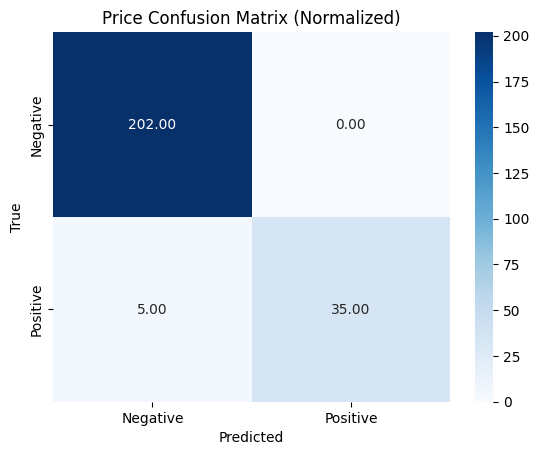

In [46]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
cm = confusion_matrix(test_target, pred)
labels = ['Negative', 'Positive']  # 이진 분류 레이블
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=labels, yticklabels=labels)
# title 에서 앞부분 본인 주제에 맞는 걸로 바꿔주세요.
plt.title('Price Confusion Matrix (Normalized)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()